<a href="https://colab.research.google.com/github/Nutsudapenpong/DPDM/blob/master/faster_rcnn_my_parasite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
!pip install -U torchvision #We need a new version of torchvision for this project

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install "opencv-python-headless<4.3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [6]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A #our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
#remove warnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [8]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu113
0.12.0+cu113


In [9]:
#our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install albumentations

In [ ]:
#! pip install albumentations==0.4.6

In [10]:
#Now we will defind our transforms

from albumentations.pytorch import ToTensorV2

In [25]:
def get_transforms(train=False):
  if train:
    transform = A.Compose([
                           A.Resize(600, 600), #our input size can be 600px
                           A.HorizontalFlip(p=0.3),
                           A.VerticalFlip(p=0.3),
                           A.RandomBrightnessContrast(p=0.1),
                           #A.ColorJitter(p=0.1),
                           ToTensorV2()
    ], bbox_params=A.BboxParams(format='coco'))
  else:
    transform = A.Compose([
                           A.Resize(600, 600),
                           ToTensorV2()#our input size can be 600px
    ], bbox_params=A.BboxParams(format='coco'))
  return transform

In [28]:
class AquariumDetection(datasets.VisionDataset):
  def __init__(self, root, split='traincoco', transform=None, target_transform=None, transforms=None):
    #the 3 transform parameers are required for datasets.VisionDataset
    super().__init__(root, transforms, transform, target_transform)
    self.split = split #train, valid, test
    self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) #annotations stored here
    self.ids = list(sorted(self.coco.imgs.keys()))
    self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
  
  def _load_image(self, id: int):
    path = self.coco.loadImgs(id)[0]['file_name']
    image = cv2.imread(os.path.join(self.root, self.split, path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
  def _load_target(self, id):
    return self.coco.loadAnns(self.coco.getAnnIds(id))

  def __getitem__(self, index):
    id = self.ids[index]
    image = self._load_image(id)
    target = self._load_target(id)
    target = copy.deepcopy(self._load_target(id))

    boxes = [t['bbox'] + [t['category_id']] for t in target] #required annotation format for albumentations
    if self.transforms is not None:
      transformed = self.transforms(image=image, bboxes=boxes)

    image = transformed['image']
    boxes = transformed['bboxes']

    new_boxes = [] #convert from xywh to xyxy
    for box in boxes:
      xmin = box[0]
      xmax = xmin + box[2]
      ymin = box[1]
      ymax = ymin + box[3]
      new_boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.tensor(new_boxes, dtype=torch.float32)

    targ = {} #here is our transformed target
    targ['boxes'] = boxes
    targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
    targ['image_id'] = torch.tensor([t['image_id'] for t in target])
    targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) #we have a different area
    targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
    return image.div(255), targ #scale images
  def __len__(self):
    return len(self.ids)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
dataset_path = "/content/drive/MyDrive/New_yolo/mydatasets"

In [22]:
#load classes
coco = COCO(os.path.join(dataset_path, "traincoco", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'parasite', 'supercategory': 'none'},
 1: {'id': 1, 'name': '0', 'supercategory': 'parasite'},
 2: {'id': 2, 'name': '1', 'supercategory': 'parasite'},
 3: {'id': 3, 'name': '2', 'supercategory': 'parasite'},
 4: {'id': 4, 'name': '3', 'supercategory': 'parasite'},
 5: {'id': 5, 'name': '4', 'supercategory': 'parasite'},
 6: {'id': 6, 'name': '5', 'supercategory': 'parasite'},
 7: {'id': 7, 'name': '6', 'supercategory': 'parasite'}}

In [23]:
classes = [i[1]['name'] for i in categories.items()]
classes

['parasite', '0', '1', '2', '3', '4', '5', '6']

In [29]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


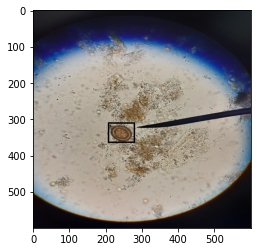

In [31]:
#Lets view a sample
sample = train_dataset[12]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [32]:
len(train_dataset)

856

In [52]:
#lets load the faster rcn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features #we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [53]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [54]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [55]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) #just make sure this runs without error

In [56]:
device = torch.device("cuda") #use GPU to train

In [57]:
model =model.to(device)

In [58]:
#Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) #lr_schedule

In [59]:
import sys

In [60]:
def train_one_epoch(model, optimizer, loader, device, epoch):
  model.to(device)
  model.train()

  #lr_scheduler = None
  #if epoch == 0:
    #warmup_factor = 1.0 / 1000 #do lr warmup
    #warmup_iters = min(1000, len(loader) - 1)

    #lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters = warmup.iters)
  
  all_losses = []
  all_losses_dict = []

  for images, targets in tqdm(loader):
    images = list(image.to(device) for image in images) 
    targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets) #the model computes the loss automatically if we pass in targets
    losses = sum(loss for loss in loss_dict.values())
    loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
    loss_value = losses.item()

    all_losses.append(loss_value)
    all_losses_dict.append(loss_dict_append)

    if not math.isfinite(loss_value):
      print(f"Loss is {loss_value}, stopping training") #train if loss becomes infinity
      print(loss_dict)
      sys.exit(1)
    
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    #if lr_scheduler is not None:
      #lr_scheduler.step()

  all_losses_dict = pd.DataFrame(all_losses_dict) #for printing
  print("Epoch {}, lr: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
      epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
      all_losses_dict['loss_classifier'].mean(),
      all_losses_dict['loss_box_reg'].mean(),
      all_losses_dict['loss_rpn_box_reg'].mean(),
      all_losses_dict['loss_objectness'].mean()
  ))

In [61]:
num_epochs = 10

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loader, device, epoch)
  #lr_scheduler.step()

100%|██████████| 214/214 [01:35<00:00,  2.24it/s]


Epoch 0, lr: 0.010000, loss_classifier: 0.761725, loss_box: 0.422139, loss_rpn_box: 0.328045, loss_object: 0.001840


100%|██████████| 214/214 [01:12<00:00,  2.93it/s]


Epoch 1, lr: 0.010000, loss_classifier: 0.651666, loss_box: 0.335251, loss_rpn_box: 0.310241, loss_object: 0.001621


100%|██████████| 214/214 [01:12<00:00,  2.93it/s]


Epoch 2, lr: 0.010000, loss_classifier: 0.539682, loss_box: 0.263789, loss_rpn_box: 0.270161, loss_object: 0.001371


100%|██████████| 214/214 [01:14<00:00,  2.86it/s]


Epoch 3, lr: 0.010000, loss_classifier: 0.550924, loss_box: 0.260595, loss_rpn_box: 0.285679, loss_object: 0.001344


100%|██████████| 214/214 [01:13<00:00,  2.91it/s]


Epoch 4, lr: 0.010000, loss_classifier: 0.484282, loss_box: 0.214642, loss_rpn_box: 0.264941, loss_object: 0.001343


100%|██████████| 214/214 [01:13<00:00,  2.92it/s]


Epoch 5, lr: 0.010000, loss_classifier: 0.475008, loss_box: 0.207583, loss_rpn_box: 0.263129, loss_object: 0.001271


100%|██████████| 214/214 [01:13<00:00,  2.92it/s]


Epoch 6, lr: 0.010000, loss_classifier: 0.440865, loss_box: 0.190338, loss_rpn_box: 0.246632, loss_object: 0.001238


100%|██████████| 214/214 [01:14<00:00,  2.86it/s]


Epoch 7, lr: 0.010000, loss_classifier: 0.419530, loss_box: 0.181316, loss_rpn_box: 0.234305, loss_object: 0.001194


100%|██████████| 214/214 [01:13<00:00,  2.92it/s]


Epoch 8, lr: 0.010000, loss_classifier: 0.447502, loss_box: 0.183955, loss_rpn_box: 0.259948, loss_object: 0.001202


100%|██████████| 214/214 [01:13<00:00,  2.91it/s]

Epoch 9, lr: 0.010000, loss_classifier: 0.455946, loss_box: 0.175416, loss_rpn_box: 0.277064, loss_object: 0.001120


In [62]:
model.eval()
torch.cuda.empty_cache()

In [63]:
test_dataset = AquariumDetection(root=dataset_path, split='testing', transforms=get_transforms(False)) 

loading annotations into memory...


FileNotFoundError: ignored

In [ ]:
img, _ = test_dataset[32]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
  prediction = model([img.to(device)])
  pred = prediction[0]

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
                               pred['boxes'][pred['scores'] > 0.8],
                               [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
                               ).permute(1, 2, 0))